In [1]:
import pandas as pd
import numpy as np
import keras_tuner as kt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dense, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import Constant
from sklearn.model_selection import train_test_split
import gensim.downloader as api

print('Libraries loaded ...')

Libraries loaded ...


In [2]:
train_df = pd.read_csv('./ED/train.csv')
train_df

,Claim,Evidence,label
0,We should legalize the growing of coca leaf,"Robert W. Sweet, a federal judge, strongly agr...",1
1,We should ban trans fats usage in food,The net increase in LDL/HDL ratio with trans f...,1
2,We should legalize prostitution,"Pertaining to health, safety and services, the...",0
3,We should subsidize investigative journalism,"Date granted: 10 June 2002 Citation: ""For serv...",0
4,We should abolish homework,The Yarrabah community has a public library wh...,0
...,...,...,...
23697,We should further exploit nuclear power,"The War Against the Atom (Basic Books, 1982) S...",0
23698,We should abolish the US Electoral College,The Constitution gives each state legislature ...,0
23699,Community service should be mandatory,Gardening From The Heart[REF] provides communi...,0
23700,Physical education should be mandatory,"In some places, the health and physical educat...",0


In [3]:
claims = train_df['Claim']
evidence = train_df['Evidence']

# tokenises input sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(claims)
tokenizer.fit_on_texts(evidence)

claims_seq = tokenizer.texts_to_sequences(claims)
evidence_seq = tokenizer.texts_to_sequences(evidence)

CLAIMS_LEN = 13 # accounts for 95% of sequences in the dataset without truncation
EVIDENCE_LEN = 65
claims_seq = pad_sequences(claims_seq, maxlen=EVIDENCE_LEN, padding='post')
evidence_seq = pad_sequences(evidence_seq, maxlen=EVIDENCE_LEN, padding='post')

In [4]:
claim_train, claim_val, evidence_train, evidence_val, y_train, y_val = train_test_split(claims_seq, evidence_seq, train_df['label'], test_size=0.2, random_state=42)

In [5]:
glove_vectors = api.load("glove-wiki-gigaword-100")

vocab_size = len(tokenizer.word_index) + 1
embedding_dim = glove_vectors.vector_size
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if word in glove_vectors:
        embedding_matrix[i] = glove_vectors[word]

In [7]:
def build_model(hp):
    claims = Input(shape=(EVIDENCE_LEN,))
    evidence = Input(shape=(EVIDENCE_LEN,))

    shared_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, embeddings_initializer=Constant(embedding_matrix), input_length=EVIDENCE_LEN, trainable=False)

    x1 = shared_embedding(claims)
    x2 = shared_embedding(evidence)
    for i in range(hp.Int('num_bilstm_layers', 1, 3)):
        dropout = hp.Float(f'dropout_{i}', min_value=0, max_value=0.5, step=0.1)
        x1 = Bidirectional(LSTM(units=hp.Choice(f'lstm_units_{i}', values=[32, 64, 128, 256]),
                                dropout=dropout,
                                recurrent_dropout=dropout,
                                return_sequences=True if i < hp.get('num_bilstm_layers') - 1 else False))(x1)
        x2 = Bidirectional(LSTM(units=hp.Choice(f'lstm_units_{i}', values=[32, 64, 128, 256]),
                                dropout=dropout,
                                recurrent_dropout=dropout,
                                return_sequences=True if i < hp.get('num_bilstm_layers') - 1 else False))(x2)

    combined = Concatenate()([x1, x2])

    for k in range(hp.Int('num_dense_layers', 1, 3)):
        combined = Dense(units=hp.Choice(f'dense_units_{k}', values=[32, 64, 128, 256]),
                         activation='relu')(combined)
        combined = Dropout(rate=hp.Float(f'dense_dropout_{k}', min_value=0, max_value=0.5, step=0.1))(combined)

    output = Dense(1, activation='sigmoid')(combined)
    
    model = Model(inputs=[claims, evidence], outputs=output)
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

    return model


In [8]:
# initialise random hyperparameter search
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=50,
    executions_per_trial=1,
    directory='hyperparam_selection',
    project_name='evidence_detection'
) 

Reloading Tuner from hyperparam_selection/evidence_detection/tuner0.json


In [ ]:
tuner.search([claim_train, evidence_train], y_train, epochs=3, validation_data=([claim_val, evidence_val], y_val))

In [21]:
tuner.save()

In [9]:
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Optimal hyperparameters: {best_hyperparameters}")

# apply best hyperparameters to model
best_model = build_model(best_hyperparameters)
best_model.compile(optimizer=Adam(learning_rate=best_hyperparameters.get('learning_rate')), loss='binary_crossentropy', metrics=['accuracy'])
best_model.fit([claim_train, evidence_train], y_train, epochs=4, validation_data=([claim_val, evidence_val], y_val))

predictions = best_model.predict([claim_val, evidence_val])

Optimal hyperparameters: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x29182ec50>


Epoch 1/4
593/593 [==============================] - 129s 187ms/step - loss: 0.4809 - accuracy: 0.7735 - val_loss: 0.4057 - val_accuracy: 0.8034
Epoch 2/4
593/593 [==============================] - 103s 173ms/step - loss: 0.4130 - accuracy: 0.8044 - val_loss: 0.4109 - val_accuracy: 0.8123
Epoch 3/4
593/593 [==============================] - 130s 220ms/step - loss: 0.3909 - accuracy: 0.8186 - val_loss: 0.3910 - val_accuracy: 0.8123
Epoch 4/4
149/149 [==============================] - 8s 27ms/step


In [10]:
import json

best_model.save_weights('./best.weights.h5')
with open('./best_hyperparameters.json', 'w') as f:
    json.dump(best_hyperparameters.values, f)

In [11]:
loss, accuracy = best_model.evaluate([claim_val, evidence_val], y_val)
print(f'Validation accuracy: {accuracy}, loss: {loss}')

149/149 [==============================] - 4s 28ms/step - loss: 0.3725 - accuracy: 0.8249
Validation accuracy: 0.8249314427375793, loss: 0.3725113272666931


In [12]:
test_df = pd.read_csv('./ED/dev.csv')
test_claims = test_df['Claim']
test_evidence = test_df['Evidence']

test_claims_seq = tokenizer.texts_to_sequences(test_claims)
test_evidence_seq = tokenizer.texts_to_sequences(test_evidence)

test_claims_seq = pad_sequences(test_claims_seq, maxlen=EVIDENCE_LEN, padding='post')
test_evidence_seq = pad_sequences(test_evidence_seq, maxlen=EVIDENCE_LEN, padding='post')

test_predictions = best_model.predict([test_claims_seq, test_evidence_seq])

186/186 [==============================] - 5s 27ms/step


In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("Accuracy:", accuracy_score(test_df['label'], test_predictions.round()))
print("Precision:", precision_score(test_df['label'], test_predictions.round()))
print("Recall:", recall_score(test_df['label'], test_predictions.round()))
print("F1:", f1_score(test_df['label'], test_predictions.round()))

Accuracy: 0.8250084373945326
Precision: 0.7078402366863905
Recall: 0.5984990619136961
F1: 0.6485936970518469


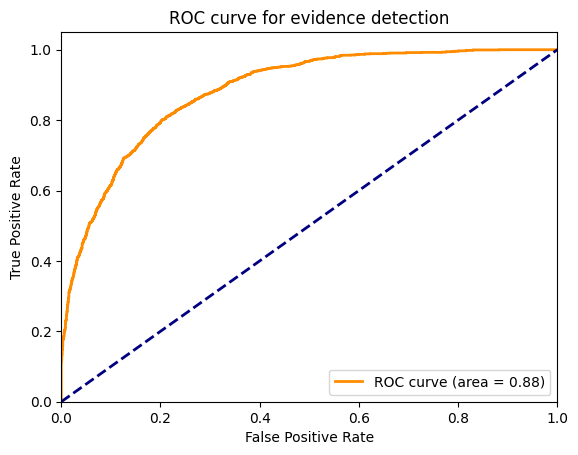

Optimal threshold: 0.32129761576652527


In [14]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(test_df['label'], test_predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for evidence detection')
plt.legend(loc="lower right")
plt.show()

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f'Optimal threshold: {optimal_threshold}')


In [15]:
test_predictions = (test_predictions > optimal_threshold).astype(int)
print("Accuracy:", accuracy_score(test_df['label'], test_predictions))
print("Precision:", precision_score(test_df['label'], test_predictions))
print("Recall:", recall_score(test_df['label'], test_predictions))
print("F1:", f1_score(test_df['label'], test_predictions))

Accuracy: 0.7973337833277084
Precision: 0.5919593345656192
Recall: 0.801125703564728
F1: 0.6808397555142174


In [16]:
# test_predictions to csv
test_predictions = pd.DataFrame(test_predictions, columns=['label'])
test_predictions.to_csv('./test_predictions.csv', index=False)